In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
cancer_data = pd.read_csv("final_prostate_data.csv")
cancer_data.shape

(7455, 39)

In [3]:
missing_pct = cancer_data.isna().mean()
low_missingness_columns = missing_pct[missing_pct == 0].index
cancer_reduced_missing = cancer_data[low_missingness_columns]
cancer_reduced_missing.shape

(7455, 36)

In [4]:
cancer_reduced_missing.sample(5)

,BMICAT_A,DIBEV_A,SMKCIGST_A,ASEV_A,COPDEV_A,HYPEV_A,AGEP_A,SKNNMCAN_A,SKNDCAN_A,MELANCAN_A,WEIGHTLBTC_A,LUNGCAN_A,LYMPHCAN_A,COLONCAN_A,HEIGHTTC_A,BLADDCAN_A,PANCRCAN_A,THROACAN_A,ESOPHCAN_A,GALLBCAN_A,BONECAN_A,LEUKECAN_A,MOUTHCAN_A,LIVERCAN_A,DEPFREQ_A,LARYNCAN_A,BREASCAN_A,REGION,RACEALLP,HOUYRSLIV_A,SMOKELSEV_A,PROSTCAN_A,CHDEV_A,LEGMSTAT_A,ORIENT_A,ECIGEV_A
4118,3,2,3,2,2,1,65,1.0,2.0,2.0,190,2.0,2.0,2.0,70,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,4,1,4,2,2.0,2,3,2.0,2
4521,2,1,3,2,2,1,77,1.0,2.0,2.0,140,2.0,2.0,2.0,67,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4,2.0,2.0,3,1,2,2,1.0,2,3,2.0,2
6181,4,2,4,1,1,1,63,2.0,2.0,2.0,285,2.0,2.0,2.0,76,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4,2.0,2.0,4,1,2,2,1.0,2,2,2.0,2
4830,2,2,4,2,2,2,65,1.0,2.0,2.0,170,2.0,2.0,2.0,74,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5,2.0,2.0,1,1,5,2,2.0,2,3,2.0,2
1186,2,2,4,9,2,1,74,1.0,2.0,2.0,150,2.0,2.0,2.0,71,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5,2.0,2.0,4,1,5,2,2.0,2,3,2.0,2


In [6]:
features = cancer_reduced_missing.drop(["PROSTCAN_A"], axis="columns")
print("Shape of data with only independent variables",features.shape)

Shape of data with only independent variables (7455, 35)


### I will be showing the variance of each column and removing columns with 0 variance. Such columns have only one value for all the rows/observations. Hence they are not useful. It may also be useful to remove some other features which do not have 0 variance but near 0 variance.

In [7]:
selector = VarianceThreshold()
selector.fit(features)

variances = pd.DataFrame({"features": features.columns, "variance":selector.variances_})
variances.sort_values(by=["variance"])

,features,variance
4,COPDEV_A,0.118487
3,ASEV_A,0.155151
1,DIBEV_A,0.199999
5,HYPEV_A,0.253057
19,GALLBCAN_A,0.334666
25,LARYNCAN_A,0.336137
26,BREASCAN_A,0.337899
16,PANCRCAN_A,0.338631
22,MOUTHCAN_A,0.340677
23,LIVERCAN_A,0.341988


In [8]:
non_zero_var_columns = variances[variances.variance > 0 ]['features'].tolist()
feature_data = features[non_zero_var_columns]
target_variable = cancer_data["PROSTCAN_A"]

In [9]:
feature_data.describe()

,BMICAT_A,DIBEV_A,SMKCIGST_A,ASEV_A,COPDEV_A,HYPEV_A,AGEP_A,SKNNMCAN_A,SKNDCAN_A,MELANCAN_A,WEIGHTLBTC_A,LUNGCAN_A,LYMPHCAN_A,COLONCAN_A,HEIGHTTC_A,BLADDCAN_A,PANCRCAN_A,THROACAN_A,ESOPHCAN_A,GALLBCAN_A,BONECAN_A,LEUKECAN_A,MOUTHCAN_A,LIVERCAN_A,DEPFREQ_A,LARYNCAN_A,BREASCAN_A,REGION,RACEALLP,HOUYRSLIV_A,SMOKELSEV_A,CHDEV_A,LEGMSTAT_A,ORIENT_A,ECIGEV_A
count,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000,7455.000000
mean,446.767136,1.829779,3.067874,1.893628,1.901945,1.390610,68.941784,1.815694,1.974514,1.980952,240.725285,2.017975,2.009256,1.990879,71.258350,1.999732,2.045607,2.032730,2.041985,2.049229,2.041046,2.027901,2.043729,2.042522,4.383635,2.047887,2.046278,2.648960,1.253119,5.115359,1.903018,1.845339,3.210731,2.143662,2.004427
std,1067.815660,0.447242,1.282880,0.393918,0.344243,0.503082,12.235266,0.732617,0.641256,0.636441,190.607645,0.606687,0.614025,0.628816,6.516088,0.621802,0.581959,0.593771,0.585334,0.578542,0.586202,0.598069,0.583714,0.584837,1.187472,0.579812,0.581329,1.010166,0.992686,3.152139,0.861395,0.590448,1.437731,0.916645,0.806538
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,126.000000,1.000000,1.000000,1.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,2.000000,2.000000,1.000000,62.000000,2.000000,2.000000,2.000000,170.000000,2.000000,2.000000,2.000000,68.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000
50%,3.000000,2.000000,3.000000,2.000000,2.000000,1.000000,71.000000,2.000000,2.000000,2.000000,190.000000,2.000000,2.000000,2.000000,70.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,3.000000,1.000000,5.000000,2.000000,2.000000,3.000000,2.000000,2.000000
75%,4.000000,2.000000,4.000000,2.000000,2.000000,2.000000,78.000000,2.000000,2.000000,2.000000,220.000000,2.000000,2.000000,2.000000,72.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,3.000000,1.000000,5.000000,2.000000,2.000000,4.000000,2.000000,2.000000
max,9999.000000,9.000000,9.000000,9.000000,9.000000,9.000000,97.000000,9.000000,9.000000,9.000000,999.000000,9.000000,9.000000,9.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,4.000000,8.000000,12.000000,9.000000,9.000000,9.000000,8.000000,9.000000


In [10]:
def convert_to_categorical(df):
    """
    Convert selected columns in a DataFrame to categorical columns if they meet the following criteria:
    - Have 14 or fewer unique numbers.
    - All non-NaN values are whole numbers without any decimals.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    pandas.DataFrame: The DataFrame with selected columns converted to categorical.
    """
    for column in df.columns:
        unique_values = df[column].dropna().unique()  # Exclude NaN values
        
        # Check if the column has 14 or fewer unique values
        if len(unique_values) <= 14:
            
            # Check if all non-NaN values are whole numbers without decimals
            if all(value == int(value) and value % 1 == 0 for value in unique_values):
                
                # Convert the column to categorical
                df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64')
                df[column] = df[column].astype('category')
    
    return df

def filter_non_categorical_columns(df):
    """
    Filters out all non-categorical columns from a pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame containing only the non-categorical columns.
    """
    non_categorical_columns = df.select_dtypes(exclude='category').columns
    return df[non_categorical_columns]


In [11]:
feature_data = convert_to_categorical(feature_data)
non_cat_data = filter_non_categorical_columns(feature_data)
non_cat_data.shape

(7455, 4)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_variable, test_size=0.2, random_state=42, stratify=target_variable)

In [14]:
y_train.value_counts(normalize=True)

PROSTCAN_A
2.0    0.702549
1.0    0.290074
9.0    0.005701
7.0    0.001677
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

PROSTCAN_A
2.0    0.702213
1.0    0.290409
9.0    0.006036
7.0    0.001341
Name: proportion, dtype: float64

In [16]:
print("Model performance without considering class imbalance")
rf = RandomForestClassifier(random_state=42)

####
rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))
####

# Make predictions on the testing set
y_test_pred = rf.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance without considering class imbalance
Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1730
         2.0       1.00      1.00      1.00      4190
         7.0       1.00      1.00      1.00        10
         9.0       1.00      1.00      1.00        34

    accuracy                           1.00      5964
   macro avg       1.00      1.00      1.00      5964
weighted avg       1.00      1.00      1.00      5964

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.88      0.91      0.89       433
         2.0       0.96      0.95      0.95      1047
         7.0       1.00      1.00      1.00         2
         9.0       1.00      1.00      1.00         9

    accuracy                           0.94      1491
   macro avg       0.96      0.96      0.96      1491
weighted avg       0.94      0.94      0.94     

In [ ]:
# Add confusion matrix

## Understand precision    recall  f1-score

In [17]:
target_variable.value_counts(normalize=True)

PROSTCAN_A
2.0    0.702482
1.0    0.290141
9.0    0.005768
7.0    0.001610
Name: proportion, dtype: float64

In [18]:
1/y_train.value_counts(normalize=True)

PROSTCAN_A
2.0      1.423389
1.0      3.447399
9.0    175.411765
7.0    596.400000
Name: proportion, dtype: float64

In [19]:
print("Model performance after considering class imbalance")
rf = RandomForestClassifier(random_state=42, class_weight={1:4,2:1,9:206,7:618})
rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))

# Make predictions on the testing set
y_test_pred = rf.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance after considering class imbalance
Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1730
         2.0       1.00      1.00      1.00      4190
         7.0       1.00      1.00      1.00        10
         9.0       1.00      1.00      1.00        34

    accuracy                           1.00      5964
   macro avg       1.00      1.00      1.00      5964
weighted avg       1.00      1.00      1.00      5964

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89       433
         2.0       0.95      0.96      0.96      1047
         7.0       1.00      1.00      1.00         2
         9.0       1.00      1.00      1.00         9

    accuracy                           0.94      1491
   macro avg       0.96      0.96      0.96      1491
weighted avg       0.94      0.94      0.94      1

In [20]:
print("Model performance after considering class imbalance")
rf = RandomForestClassifier(random_state=42, class_weight={1:4,2:1,9:20,7:61})
rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))

# Make predictions on the testing set
y_test_pred = rf.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance after considering class imbalance
Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1730
         2.0       1.00      1.00      1.00      4190
         7.0       1.00      1.00      1.00        10
         9.0       1.00      1.00      1.00        34

    accuracy                           1.00      5964
   macro avg       1.00      1.00      1.00      5964
weighted avg       1.00      1.00      1.00      5964

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89       433
         2.0       0.95      0.95      0.95      1047
         7.0       1.00      1.00      1.00         2
         9.0       1.00      1.00      1.00         9

    accuracy                           0.93      1491
   macro avg       0.96      0.96      0.96      1491
weighted avg       0.93      0.93      0.93      1

In [21]:
feature_importance = pd.DataFrame({"features": X_train.columns, "importance":rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

In [22]:

def plot_top_features(df, top_n=20):
    # Sort the DataFrame by importance in descending order
    df_sorted = df.sort_values(by='importance', ascending=False)

    # Select the top N features
    top_features = df_sorted.head(top_n)

    # Aggregate other features into a new row called 'Others'
    other_features = df_sorted.iloc[top_n:]
    others_row = pd.DataFrame({'features': ['Others'], 'importance': [other_features['importance'].sum()]})
    df_aggregated = pd.concat([top_features, others_row])

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Plot the horizontal bar chart using seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='features', data=df_aggregated, color='skyblue')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(f'Top {top_n} Features and Others', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

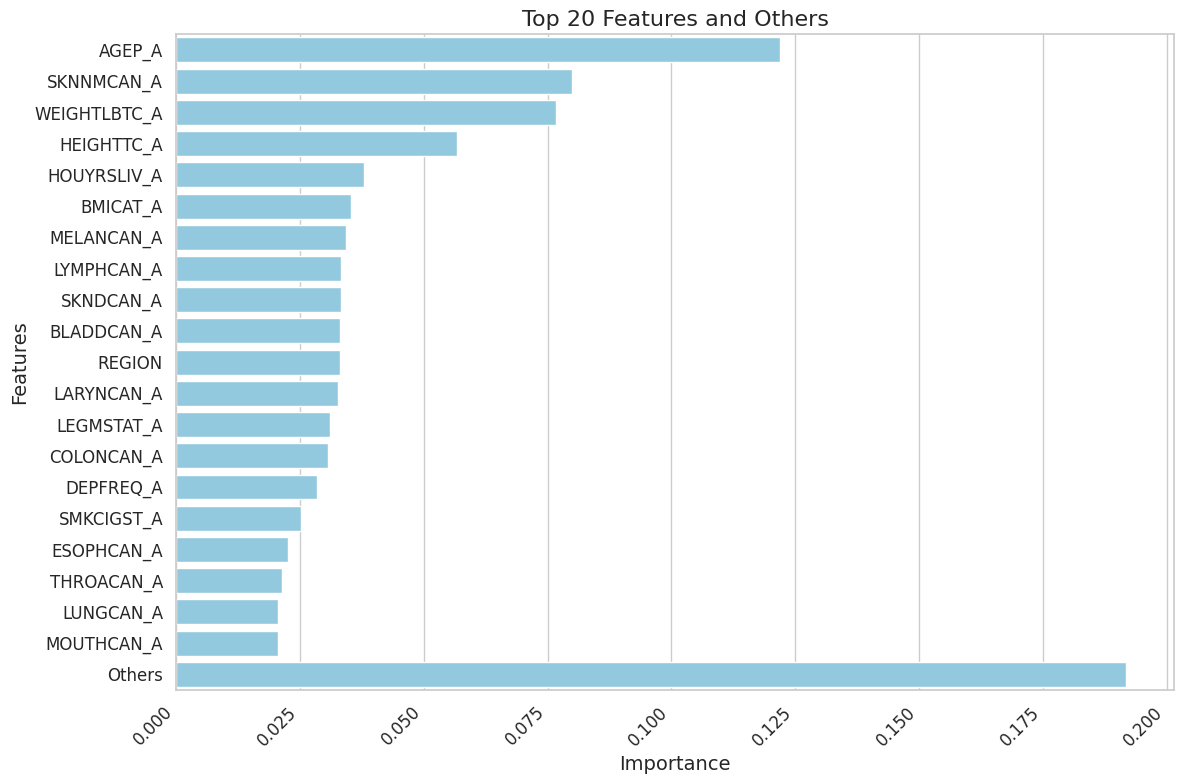

In [26]:
plot_top_features(feature_importance, top_n=20)

In [27]:
def add_cumulative_percentage(df):
    # Make sure the 'importance' column is numeric
    df['importance'] = pd.to_numeric(df['importance'], errors='coerce')

    # Calculate cumulative percentage
    df['cumulative_percentage'] = (df['importance'].cumsum() / df['importance'].sum()) * 100

    # Fill any NaN values with 0 in case there are missing values in 'importance' column
    df['cumulative_percentage'].fillna(0, inplace=True)

    return df

feature_importance = add_cumulative_percentage(feature_importance)

In [28]:
feature_importance.head(50)

,features,importance,cumulative_percentage
6,AGEP_A,0.121920,12.191975
7,SKNNMCAN_A,0.079959,20.187908
10,WEIGHTLBTC_A,0.076657,27.853573
14,HEIGHTTC_A,0.056730,33.526621
29,HOUYRSLIV_A,0.037888,37.315416
0,BMICAT_A,0.035190,40.834453
9,MELANCAN_A,0.034340,44.268494
12,LYMPHCAN_A,0.033198,47.588313
8,SKNDCAN_A,0.033195,50.907808
15,BLADDCAN_A,0.033121,54.219900


In [57]:
most_important_features = feature_importance.head(50).features.tolist()
X_train, X_test, y_train, y_test = train_test_split(feature_data[most_important_features], target_variable, test_size=0.2, random_state=42, stratify=target_variable)

In [58]:
print("Model performance after considering class imbalance")
rf_model = RandomForestClassifier(random_state=4212, class_weight={1:4,2:1,9:20,7:61})
rf_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))

# Make predictions on the testing set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance after considering class imbalance
Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       356
         2.0       1.00      1.00      1.00       872
         7.0       1.00      1.00      1.00         2
         9.0       1.00      1.00      1.00         6

    accuracy                           1.00      1236
   macro avg       1.00      1.00      1.00      1236
weighted avg       1.00      1.00      1.00      1236

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.88      0.64      0.74        89
         2.0       0.87      0.96      0.91       219
         9.0       1.00      1.00      1.00         2

    accuracy                           0.87       310
   macro avg       0.92      0.87      0.88       310
weighted avg       0.87      0.87      0.86       310



## Tuning Hyperparameters for better performance

In [29]:
# Define the Random Forest Classifier
rf_classifier = RandomForestClassifier(class_weight={1:4,2:1,9:20,7:61})

# Define the hyperparameters and their possible values for tuning
param_dist = {
    'criterion': ["gini", "entropy", "log_loss"],
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4,8],
    'bootstrap': [True, False]
}

# Use F1 score as the scoring metric
scorer = make_scorer(f1_score, average='weighted')  # Adjust 'average' parameter as needed

# Use RandomizedSearchCV for hyperparameter tuning with F1 score
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring=scorer, n_jobs=-1, random_state=4212)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_model = random_search.best_estimator_

# Evaluate the model on the test set using F1 score
y_pred = best_rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust 'average' parameter as needed
print("Test F1 Score:", f1)

Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Test F1 Score: 0.9349209128060586


In [60]:
print("Model performance after hyperparameters tuning")
# Make predictions on the training set
y_train_pred = best_rf_model.predict(X_train)

# Evaluate the model using classification report
print("Classification report on the training set")
print(classification_report(y_train, y_train_pred))

# Make predictions on the testing set
y_test_pred = best_rf_model.predict(X_test)

# Evaluate the model using classification report
print("Classification report on the testing set")
print(classification_report(y_test, y_test_pred))

Model performance after hyperparameters tuning
Classification report on the training set
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       356
         2.0       1.00      1.00      1.00       872
         7.0       1.00      1.00      1.00         2
         9.0       1.00      1.00      1.00         6

    accuracy                           1.00      1236
   macro avg       1.00      1.00      1.00      1236
weighted avg       1.00      1.00      1.00      1236

Classification report on the testing set
              precision    recall  f1-score   support

         1.0       0.80      0.73      0.76        89
         2.0       0.89      0.93      0.91       219
         9.0       1.00      1.00      1.00         2

    accuracy                           0.87       310
   macro avg       0.90      0.89      0.89       310
weighted avg       0.87      0.87      0.87       310



### Using all Data

In [2]:
all_data = pd.read_csv("final_prostate_data.csv")

In [3]:
all_data.shape

(7455, 39)

In [7]:
all_data.PROSTCAN_A.value_counts(normalize=True)

PROSTCAN_A
2.0    0.702482
1.0    0.290141
9.0    0.005768
7.0    0.001610
Name: proportion, dtype: float64

In [9]:
all_data.isna().mean().sort_values(ascending=False)

OTHERCANP_A     0.153320
ANXFREQ_A       0.152247
PSATEST_A       0.029913
BMICAT_A        0.000000
LEUKECAN_A      0.000000
MOUTHCAN_A      0.000000
LIVERCAN_A      0.000000
DEPFREQ_A       0.000000
LARYNCAN_A      0.000000
BREASCAN_A      0.000000
REGION          0.000000
RACEALLP        0.000000
GALLBCAN_A      0.000000
HOUYRSLIV_A     0.000000
SMOKELSEV_A     0.000000
PROSTCAN_A      0.000000
CHDEV_A         0.000000
LEGMSTAT_A      0.000000
ORIENT_A        0.000000
BONECAN_A       0.000000
ESOPHCAN_A      0.000000
DIBEV_A         0.000000
THROACAN_A      0.000000
SMKCIGST_A      0.000000
ASEV_A          0.000000
COPDEV_A        0.000000
HYPEV_A         0.000000
AGEP_A          0.000000
SKNNMCAN_A      0.000000
SKNDCAN_A       0.000000
MELANCAN_A      0.000000
WEIGHTLBTC_A    0.000000
LUNGCAN_A       0.000000
LYMPHCAN_A      0.000000
COLONCAN_A      0.000000
HEIGHTTC_A      0.000000
BLADDCAN_A      0.000000
PANCRCAN_A      0.000000
ECIGEV_A        0.000000
dtype: float64